**// IMPORTS**

In [2]:
import pandas as pd
import numpy as np
import pathlib
import missingno as msno
import random as rn
import re, unicodedata
import itertools
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

pd.set_option("display.max_colwidth", None)



**// CONFIGS**

In [3]:
# --- basic text normalization (keeps digits, lowercases, strips punctuation/spaces) ---
PUNCT_RE = re.compile(r"[^\w\s]+", re.UNICODE)
AUTHOR_DELIMS = re.compile(r"\s*(?:;|\band\b|&|\|)\s*", flags=re.I)
DBLP_PATH   = "DBLP1_dedup.csv"
SCHOLAR_PATH= "Scholar_dedup.csv"
GOLD_PATH   = "../data/DBLP-Scholar_perfectMapping.csv"

# TUNING KNOBS
TITLE_PREFIX_K = 4       # 2–4 is common; start at 3
YEAR_WINDOW    = 1       # allow ±1 year
MIN_OVERLAP    = 1       # min shared last names when both years known
MIN_OV_MISSING = 2       # min overlap if a year is missing
LARGE_TEAM_N   = 4       # "large team" if >4 authors
LARGE_TEAM_REQ = 2       # require ≥ this many overlaps for large teams

**// LOAD DATASETS**

In [4]:
data_dir = pathlib.Path("../data/")
# Try reading with 'latin1' encoding which can handle most special characters
dblp_data = pd.read_csv(data_dir / "DBLP1.csv", encoding='latin1')
scholar_data = pd.read_csv(data_dir / "Scholar.csv", encoding='utf-8-sig')
gold_data = pd.read_csv(data_dir / "DBLP-Scholar_perfectMapping.csv", encoding='utf-8-sig')

In [5]:
scholar_data[scholar_data['id'] == "F9KzvnDpCPUJ"]

,id,title,authors,venue,year
51305,F9KzvnDpCPUJ,Similarity-based queries for time series data. In: Proceedings of the ACM SIGMOD Conference on the,"D Raflei, A Mendelzon",NaN,1997.0


In [6]:
scholar_data[scholar_data['id'] == "UBACGF9cQ2UJ"]

,id,title,authors,venue,year
3472,UBACGF9cQ2UJ,Similarity-based queries for time series data,"D Raei, A Mendelzon","Proc. ACM SIGMOD,",1997.0


In [7]:
dblp_data[dblp_data['id'] == 'conf/sigmod/RafieiM97']

,id,title,authors,venue,year
1324,conf/sigmod/RafieiM97,Similarity-Based Queries for Time Series Data,"D Rafiei, A Mendelzon",SIGMOD Conference,1997


<Axes: >

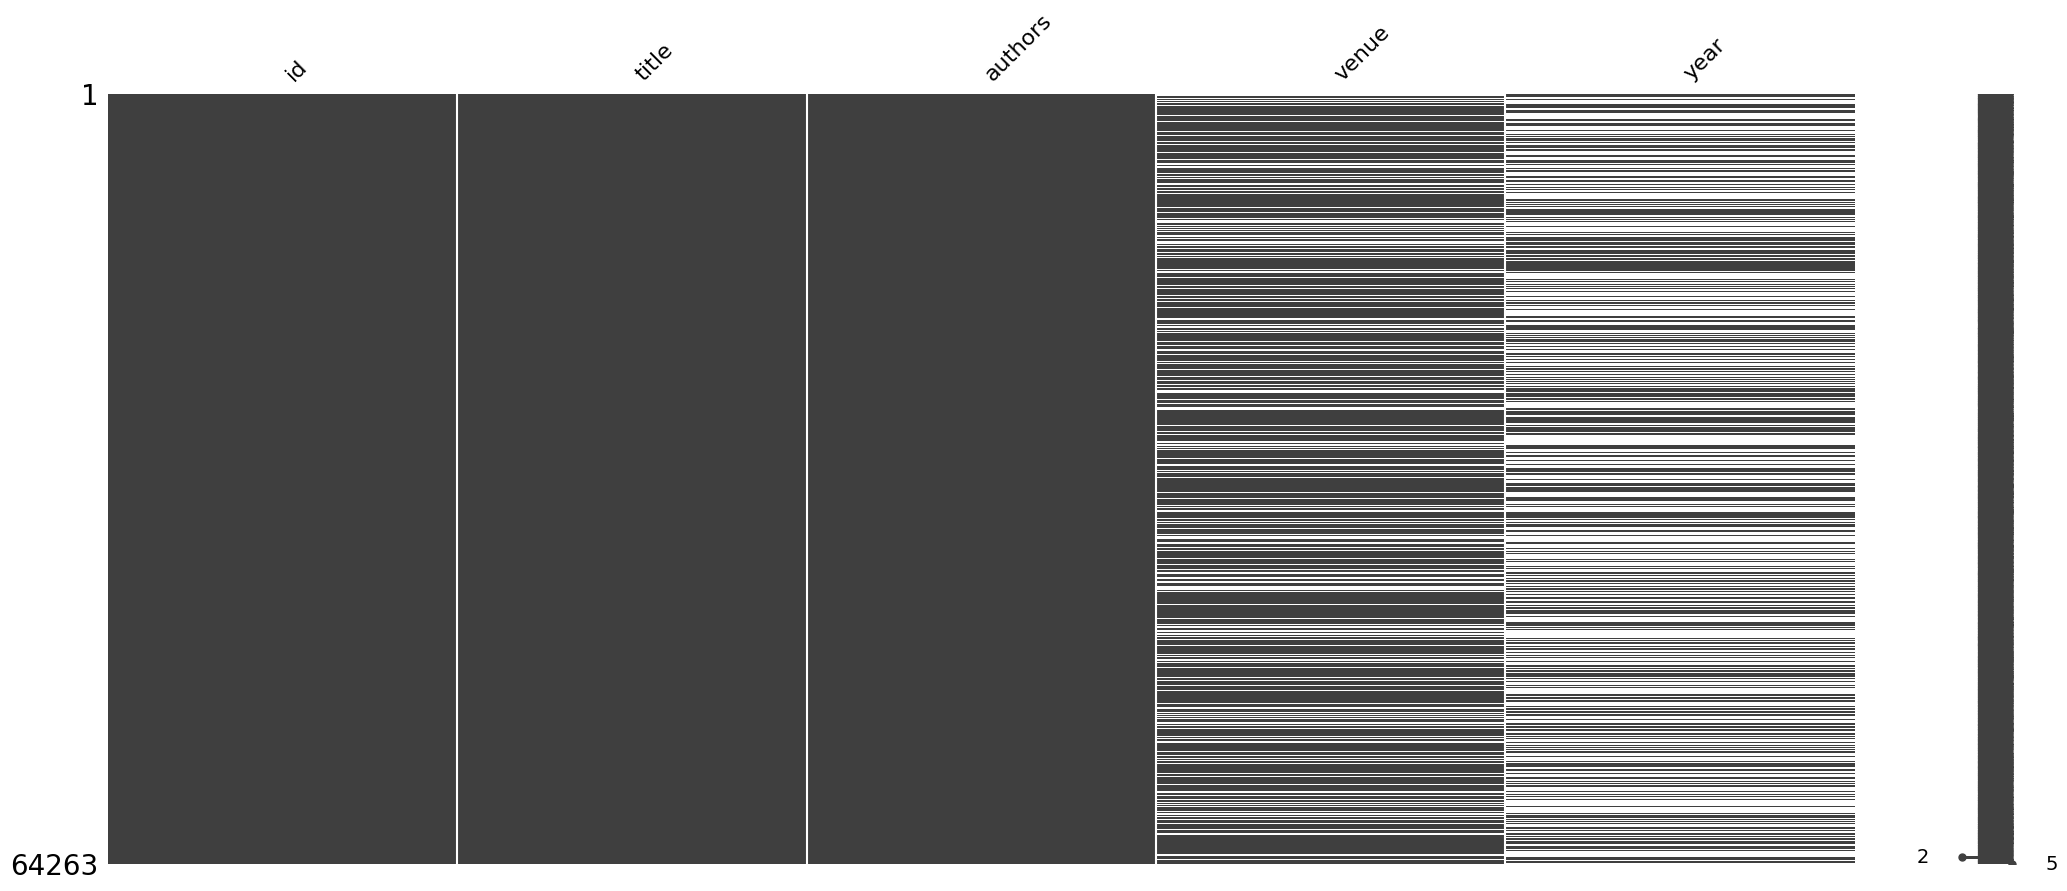

In [8]:
msno.matrix(scholar_data)

In [9]:
null_ids_dblp = dblp_data['id'].notna().count
print('Null ids dblp: ', null_ids_dblp)
print("Number rows dblp: ", dblp_data.shape[0])

Null ids dblp:  <bound method Series.count of 0       True
1       True
2       True
3       True
4       True
        ... 
2611    True
2612    True
2613    True
2614    True
2615    True
Name: id, Length: 2616, dtype: bool>
Number rows dblp:  2616


In [10]:
null_ids_scholar = scholar_data['id'].notna().count
print('Null ids dblp: ', null_ids_scholar)
print("Number rows dblp: ", scholar_data.shape[0])

Null ids dblp:  <bound method Series.count of 0        True
1        True
2        True
3        True
4        True
         ... 
64258    True
64259    True
64260    True
64261    True
64262    True
Name: id, Length: 64263, dtype: bool>
Number rows dblp:  64263


**// TASK_01**

**// 1.1**

In [11]:
def normalize_text(x) -> str:
    if pd.isna(x):
        return ""
    x = unicodedata.normalize("NFKC", str(x)).lower()
    x = PUNCT_RE.sub(" ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

# TITLE TOKENIZATION

def tokenize_title(title_norm: str):
    return title_norm.split() if isinstance(title_norm, str) else []

# AUTHOR LAST NAME EXTRACTION

def _last_token_norm(s: str) -> str:
    s = unicodedata.normalize("NFKC", s).lower().strip()
    s = re.sub(r"[^\w\s\-]", "", s)   # keep letters/digits/hyphens
    toks = s.split()
    return toks[-1] if toks else ""

def _last_from_segment(seg: str) -> str:
    seg = seg.strip()
    # "Last, First ..." → take text before first comma
    if "," in seg:
        seg = seg.split(",", 1)[0].strip()
        return _last_token_norm(seg)
    # "First ... Last" → take last token
    return _last_token_norm(seg)

def extract_last_names_any_format(authors_raw) -> list[str]:
    if pd.isna(authors_raw) or not str(authors_raw).strip():
        return []
    s = unicodedata.normalize("NFKC", str(authors_raw))
    s = re.sub(r"\s+", " ", s).strip()
    s = re.sub(r"\bet\s*al\.?$", "", s, flags=re.I).strip()

    # unify explicit multi-author delimiters
    s = AUTHOR_DELIMS.sub(";", s)

    if ";" in s:
        segs = [p for p in s.split(";") if p.strip()]
        return [ln for ln in (_last_from_segment(p) for p in segs) if ln]

    # No ';' → comma-separated scenarios:
    parts = [p.strip() for p in s.split(",") if p.strip()]
    if len(parts) <= 1:
        ln = _last_from_segment(s)
        return [ln] if ln else []

    # Heuristic 1: if every comma-part has a space, it's likely "Init Last" pieces → each is an author
    if all(" " in p for p in parts):
        return [ln for ln in (_last_from_segment(p) for p in parts) if ln]

    # Heuristic 2: assume "Last, First, Last, First, ..." → take every 1st, 3rd, ...
    lastnames = []
    for i in range(0, len(parts), 2):
        ln = _last_token_norm(parts[i])
        if ln:
            lastnames.append(ln)
    return lastnames

# YEAR PARSING

def parse_year_any(x):
    # handles numeric like 1995.0 and strings like "2016 (online 2017)"
    try:
        y = pd.to_numeric(str(x), errors="raise")
        yi = int(y)
        if 1800 <= yi <= 2100:
            return yi
    except Exception:
        pass
    m = re.search(r"(18|19|20)\d{2}", str(x))
    return int(m.group(0)) if m else np.nan

# --- dataframe helpers ---
def sanitize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns
          .str.replace(r'^\ufeff', '', regex=True)  # strip BOM
          .str.replace('"', '', regex=False)
          .str.strip()
          .str.lower()
    )
    return df

def ensure_standard_columns(df: pd.DataFrame) -> pd.DataFrame:
    # ensure the canonical set exists; create missing as NaN
    for c in ["id","title","authors","venue","year"]:
        if c not in df.columns:
            df[c] = np.nan
    return df[["id","title","authors","venue","year"]].copy()

# FINAL CLEANING & NORMALIZATION PIPELINE

def clean_and_normalize(df: pd.DataFrame) -> pd.DataFrame:
    df = sanitize_columns(df)
    df = ensure_standard_columns(df)

    # id as trimmed string (do NOT drop here)
    df["id"] = df["id"].astype(str).str.strip()

    # normalized text fields
    df["title_norm"]   = df["title"].apply(normalize_text)
    df["authors_norm"] = df["authors"].apply(normalize_text)
    df["venue_norm"]   = df["venue"].apply(normalize_text)  # simple normalization only

    # derived fields
    df["title_tokens"] = df["title_norm"].apply(tokenize_title)
    df["authors_last"] = df["authors"].apply(extract_last_names_any_format)
    df["year_parsed"]  = df["year"].apply(parse_year_any).astype("Int64")

    return df

In [12]:
dblp_clean    = clean_and_normalize(dblp_data)
scholar_clean = clean_and_normalize(scholar_data)

# dblp_clean.to_csv("DBLP1_clean.csv", index=False)
# scholar_clean.to_csv("Scholar_clean.csv", index=False)

In [13]:
dblp_clean.head()

,id,title,authors,venue,year,title_norm,authors_norm,venue_norm,title_tokens,authors_last,year_parsed
0,conf/vldb/RusinkiewiczKTWM95,Towards a Cooperative Transaction Model - The Cooperative Activity Model,"M Rusinkiewicz, W Klas, T Tesch, J Wäsch, P Muth",VLDB,1995,towards a cooperative transaction model the cooperative activity model,m rusinkiewicz w klas t tesch j wäsch p muth,vldb,"[towards, a, cooperative, transaction, model, the, cooperative, activity, model]","[rusinkiewicz, klas, tesch, wäsch, muth]",1995
1,journals/sigmod/EisenbergM02,SQL/XML is Making Good Progress,"A Eisenberg, J Melton",SIGMOD Record,2002,sql xml is making good progress,a eisenberg j melton,sigmod record,"[sql, xml, is, making, good, progress]","[eisenberg, melton]",2002
2,conf/vldb/AmmannJR95,Using Formal Methods to Reason about Semantics-Based Decompositions of Transactions,"P Ammann, S Jajodia, I Ray",VLDB,1995,using formal methods to reason about semantics based decompositions of transactions,p ammann s jajodia i ray,vldb,"[using, formal, methods, to, reason, about, semantics, based, decompositions, of, transactions]","[ammann, jajodia, ray]",1995
3,journals/sigmod/Liu02,Editor's Notes,L Liu,SIGMOD Record,2002,editor s notes,l liu,sigmod record,"[editor, s, notes]",[liu],2002
4,journals/sigmod/Hammer02,Report on the ACM Fourth International Workshop on Data Warehousing and OLAP (DOLAP 2001),NaN,NaN,2002,report on the acm fourth international workshop on data warehousing and olap dolap 2001,,,"[report, on, the, acm, fourth, international, workshop, on, data, warehousing, and, olap, dolap, 2001]",[],2002


In [14]:
scholar_clean.head()

,id,title,authors,venue,year,title_norm,authors_norm,venue_norm,title_tokens,authors_last,year_parsed
0,aKcZKwvwbQwJ,11578 Sorrento Valley Road,QD Inc,"San Diego,",NaN,11578 sorrento valley road,qd inc,san diego,"[11578, sorrento, valley, road]",[inc],<NA>
1,ixKfiTHoaDoJ,Initiation of crazes in polystyrene,"AS Argon, JG Hannoosh","Phil. Mag,",NaN,initiation of crazes in polystyrene,as argon jg hannoosh,phil mag,"[initiation, of, crazes, in, polystyrene]","[argon, hannoosh]",<NA>
2,3BxllB4wwcIJ,Immunogold labelling is a quantitative method as demonstrated by studies on aminopeptidase N in,"GH Hansen, LL Wetterberg, H SjÃ¶strÃ¶m, O NorÃ©n","The Histochemical Journal,",1992.0,immunogold labelling is a quantitative method as demonstrated by studies on aminopeptidase n in,gh hansen ll wetterberg h sjã strã m o norã n,the histochemical journal,"[immunogold, labelling, is, a, quantitative, method, as, demonstrated, by, studies, on, aminopeptidase, n, in]","[hansen, wetterberg, sjãstrãm, norãn]",1992
3,d2WWxwKMex4J,The Burden of Infectious Disease Among Inmates and Releasees From Correctional Facilities,"TM Hammett, P Harmon, W Rhodes",see,NaN,the burden of infectious disease among inmates and releasees from correctional facilities,tm hammett p harmon w rhodes,see,"[the, burden, of, infectious, disease, among, inmates, and, releasees, from, correctional, facilities]","[hammett, harmon, rhodes]",<NA>
4,cZCX-AQpjccJ,The Role of Faculty Advising in Science and Engineering,JR Cogdell,"NEW DIRECTIONS FOR TEACHING AND LEARNING,",1995.0,the role of faculty advising in science and engineering,jr cogdell,new directions for teaching and learning,"[the, role, of, faculty, advising, in, science, and, engineering]",[cogdell],1995


In [15]:
def apply_jaccard_similarity(set1: set, set2: set) -> float:
    if not set1 and not set2:
        return 1.0
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def _title_prefix(tokens, k=4):
    return " ".join(tokens[:k]) if isinstance(tokens, list) else ""

def dedup_title_authors_then_years_with_logging(
    df: pd.DataFrame,
    *,
    title_norm_col: str = "title_norm",
    authors_last_col: str = "authors_last",
    year_col: str = "year_parsed",
    id_col: str = "id",
    year_window: int = 1,
    print_examples: int = 15,
    to_csv: str | None = None
):
    """
    Deduplicate within ONE table by groups of identical title_norm:
      1) Prefer rule: authors_equal (non-empty sets) AND years_close  -> drop
      2) Fallback only when authors missing on either side: years_close -> drop
      Else: keep.
    Returns: dedup_df, report_dict, log_df
    """
    for c in (title_norm_col, authors_last_col, year_col):
        if c not in df.columns:
            raise ValueError(f"Missing required column: {c}")

    work = df.reset_index(drop=True).copy()
    work["_orig_idx"] = np.arange(len(work))

    keep = np.ones(len(work), dtype=bool)
    events = []

    def A(x):  # authors set (empty if missing)
        return set(x) if isinstance(x, list) else set()

    def years_close(y1, y2):
        return pd.notna(y1) and pd.notna(y2) and abs(int(y1) - int(y2)) <= year_window

    # Process groups with identical normalized titles
    for t, grp in work.groupby(title_norm_col, dropna=False):
        idxs = list(grp.index)
        if len(idxs) < 2:
            continue

        # maintain representatives we've kept in this title group
        kept_in_group = []
        for j in idxs:
            if not keep[j]:
                continue

            Aj = A(work.at[j, authors_last_col])
            Yj = work.at[j, year_col]
            dropped = False

            # compare against each already-kept representative for the same title
            for i in kept_in_group:
                Ai = A(work.at[i, authors_last_col])
                Yi = work.at[i, year_col]

                authors_equal = (Ai == Aj and len(Ai) > 0)  # both non-empty & identical
                missing_auth  = (len(Ai) == 0) or (len(Aj) == 0)

                if authors_equal and years_close(Yi, Yj):
                    # Rule 1: authors match AND years close
                    keep[j] = False
                    events.append({
                        "decision": "STRICT_TITLE",
                        "reason": "AUTHORS_EQUAL_AND_YEARS_WITHIN_WINDOW",
                        "kept_row": int(work.at[i, "_orig_idx"]),
                        "dropped_row": int(work.at[j, "_orig_idx"]),
                        "kept_id":  work.at[i, id_col] if id_col in work.columns else None,
                        "dropped_id": work.at[j, id_col] if id_col in work.columns else None,
                        "kept_title":  work.at[i, title_norm_col],
                        "dropped_title": work.at[j, title_norm_col],
                        "authors_kept":  sorted(list(Ai)),
                        "authors_dropped": sorted(list(Aj)),
                        "year_kept":  work.at[i, year_col],
                        "year_dropped": work.at[j, year_col],
                    })
                    dropped = True
                    break

                # Rule 2: ONLY if authors missing on either side, allow title+years close
                if missing_auth and years_close(Yi, Yj):
                    keep[j] = False
                    events.append({
                        "decision": "STRICT_TITLE",
                        "reason": "TITLE_AND_YEARS_ONLY_DUE_TO_MISSING_AUTHORS",
                        "kept_row": int(work.at[i, "_orig_idx"]),
                        "dropped_row": int(work.at[j, "_orig_idx"]),
                        "kept_id":  work.at[i, id_col] if id_col in work.columns else None,
                        "dropped_id": work.at[j, id_col] if id_col in work.columns else None,
                        "kept_title":  work.at[i, title_norm_col],
                        "dropped_title": work.at[j, title_norm_col],
                        "authors_kept":  sorted(list(Ai)),
                        "authors_dropped": sorted(list(Aj)),
                        "year_kept":  work.at[i, year_col],
                        "year_dropped": work.at[j, year_col],
                    })
                    dropped = True
                    break

            if not dropped:
                kept_in_group.append(j)

    out = work[keep].drop(columns=["_orig_idx"]).reset_index(drop=True)
    report = {
        "input_rows": len(df),
        "strict_dups_dropped": int((~keep).sum()),
        "unique_rows": len(out),
    }
    log_cols = ["decision","reason","kept_row","dropped_row","kept_id","dropped_id",
                "kept_title","dropped_title","authors_kept","authors_dropped",
                "year_kept","year_dropped"]
    log_df = pd.DataFrame(events, columns=log_cols)

    if print_examples and not log_df.empty:
        n = min(print_examples, len(log_df))
        print(f"\n--- Examples of drops (first {n}) ---")
        for _, r in log_df.head(n).iterrows():
            print(f"[{r.decision}:{r.reason}] DROP {r.dropped_id} ⇐ KEEP {r.kept_id} "
                  f"| Years=({r.year_kept},{r.year_dropped})")
            print("   KEEP: ", str(r.kept_title)[:160])
            print("   DROP: ", str(r.dropped_title)[:160])
            print("   Authors kept:", r.authors_kept, " | dropped:", r.authors_dropped)

    if to_csv:
        log_df.to_csv(to_csv, index=False)
    return out, report, log_df

In [16]:
dedup_dblp, report_dblp, log_dblp = dedup_title_authors_then_years_with_logging(dblp_clean)
dedup_scholar, report_scholar, log_scholar = dedup_title_authors_then_years_with_logging(scholar_clean)


--- Examples of drops (first 15) ---
[STRICT_TITLE:AUTHORS_EQUAL_AND_YEARS_WITHIN_WINDOW] DROP journals/vldb/RamamurthyDS03 ⇐ KEEP conf/vldb/RamamurthyDS02 | Years=(2002,2003)
   KEEP:  a case for fractured mirrors
   DROP:  a case for fractured mirrors
   Authors kept: ['dewitt', 'ramamurthy', 'su']  | dropped: ['dewitt', 'ramamurthy', 'su']
[STRICT_TITLE:AUTHORS_EQUAL_AND_YEARS_WITHIN_WINDOW] DROP journals/vldb/ChirkovaHS02 ⇐ KEEP conf/vldb/ChirkovaHS01 | Years=(2001,2002)
   KEEP:  a formal perspective on the view selection problem
   DROP:  a formal perspective on the view selection problem
   Authors kept: ['chirkova', 'halevy', 'suciu']  | dropped: ['chirkova', 'halevy', 'suciu']
[STRICT_TITLE:AUTHORS_EQUAL_AND_YEARS_WITHIN_WINDOW] DROP journals/vldb/ChakrabartiGRS01 ⇐ KEEP conf/vldb/ChakrabartiGRS00 | Years=(2000,2001)
   KEEP:  approximate query processing using wavelets
   DROP:  approximate query processing using wavelets
   Authors kept: ['chakrabarti', 'garofalakis', 'rast

In [17]:
log_dblp.value_counts('decision')

decision
STRICT_TITLE    91
Name: count, dtype: int64

In [18]:
log_scholar.value_counts('decision')

decision
STRICT_TITLE    30
Name: count, dtype: int64

In [19]:
dedup_dblp[dedup_dblp['id'] == 'journals/sigmod/PoessF00']

,id,title,authors,venue,year,title_norm,authors_norm,venue_norm,title_tokens,authors_last,year_parsed
310,journals/sigmod/PoessF00,New TPC Benchmarks for Decision Support and Web Commerce,"M Pöss, C Floyd",SIGMOD Record,2000,new tpc benchmarks for decision support and web commerce,m pöss c floyd,sigmod record,"[new, tpc, benchmarks, for, decision, support, and, web, commerce]","[pöss, floyd]",2000


In [20]:
dedup_scholar[dedup_scholar['id'] == 'url:http://portal.acm.org/ft_gateway.cfm%3Fid%3D369291%26type%3Dpdf%26dl%3DGUIDE%26dl%3DACM%26CFID%3D11111111%26CFTOKEN%3D2222222']

,id,title,authors,venue,year,title_norm,authors_norm,venue_norm,title_tokens,authors_last,year_parsed
35120,url:http://portal.acm.org/ft_gateway.cfm%3Fid%3D369291%26type%3Dpdf%26dl%3DGUIDE%26dl%3DACM%26CFID%3D11111111%26CFTOKEN%3D2222222,New TPC Benchmarks for Decision Support and Web Commerce,GC Introduction,"SIGMOD Record,",2000.0,new tpc benchmarks for decision support and web commerce,gc introduction,sigmod record,"[new, tpc, benchmarks, for, decision, support, and, web, commerce]",[introduction],2000


In [21]:
log_dblp[log_dblp['kept_id'] == 'conf/sigmod/RafieiM97']

,decision,reason,kept_row,dropped_row,kept_id,dropped_id,kept_title,dropped_title,authors_kept,authors_dropped,year_kept,year_dropped


In [22]:
log_scholar[log_scholar['dropped_id'] == 'url:http://portal.acm.org/ft_gateway.cfm%3Fid%3D369291%26type%3Dpdf%26dl%3DGUIDE%26dl%3DACM%26CFID%3D11111111%26CFTOKEN%3D2222222']

,decision,reason,kept_row,dropped_row,kept_id,dropped_id,kept_title,dropped_title,authors_kept,authors_dropped,year_kept,year_dropped


In [23]:
log_scholar[log_scholar.decision == "RELAXED"].head(10)

,decision,reason,kept_row,dropped_row,kept_id,dropped_id,kept_title,dropped_title,authors_kept,authors_dropped,year_kept,year_dropped


In [24]:
import pandas as pd

# Set this to your gold path
GOLD_PATH = "../data/DBLP-Scholar_perfectMapping.csv"  # or data_dir / "DBLP-Scholar_perfectMapping.csv"

gold = pd.read_csv(GOLD_PATH, encoding="utf-8-sig")
dblp_col, sch_col = gold.columns[:2]

# Normalize to strings (trim whitespace)
sch_alive = set(dedup_scholar["id"].astype(str).str.strip())
sch_in_gold = set(gold[sch_col].astype(str).str.strip())

missing_sch = sch_in_gold - sch_alive
print(f"Scholar IDs in gold: {len(sch_in_gold)}")
print(f"Missing from dedup_scholar: {len(missing_sch)}")

# Show some missing Scholar IDs
sample_n = 20
missing_list = list(missing_sch)[:sample_n]
print("\nSample missing Scholar IDs:")
for sid in missing_list:
    print(sid)

# Also show their paired DBLP IDs from gold (for context)
print("\nSample missing gold pairs (DBLP_id, Scholar_id):")
sample_pairs = gold[gold[sch_col].astype(str).str.strip().isin(missing_list)][[dblp_col, sch_col]].head(sample_n)
print(sample_pairs.to_string(index=False))


Scholar IDs in gold: 5218
Missing from dedup_scholar: 17

Sample missing Scholar IDs:
HhdW2CaIIZwJ
jQ6eIao6R0EJ
Vj1kbPjzSHwJ
uzpyy9XRpgYJ
QZyUtlmyn1UJ
url:http://portal.acm.org/ft_gateway.cfm%3Fid%3D641004%26type%3Dpdf%26dl%3DGUIDE%26dl%3DACM%26CFID%3D11111111%26CFTOKEN%3D2222222
KVEv4thH4CgJ
yP4hDOd65VUJ
nsN_2BnT_mMJ
7j1pKfzfgNYJ
Bcuo4_yr2p0J
_6wwPJEGUiAJ
eHY42LnL_lsJ
hvMTb3FYOjQJ
MUXTIMdJLjgJ
gYELZxhiJx8J
fhbW320LsusJ

Sample missing gold pairs (DBLP_id, Scholar_id):
                        idDBLP                                                                                                                         idScholar
        conf/sigmod/Blakeley96                                                                                                                      jQ6eIao6R0EJ
     conf/sigmod/ChaudhuriMN98                                                                                                                      hvMTb3FYOjQJ
           conf/sigmod/ColeG94             

**// BLOCKING**

In [25]:
def read_gold_pairs(path):
    gold = pd.read_csv(path, encoding="utf-8-sig")
    cols = list(gold.columns)
    if len(cols) < 2:
        raise ValueError("Gold mapping needs ≥2 columns (DBLP_id, Scholar_id).")
    a, b = cols[0], cols[1]
    pairs = set(map(tuple, gold[[a, b]].astype(str).itertuples(index=False, name=None)))
    return pairs, (a, b)

def union_pairs(list_of_sets):
    out = set()
    for s in list_of_sets:
        out |= s
    return out

def attach_ids_and_eval(pairs, dblp, schol, gold_path):
    df = pd.DataFrame(list(pairs), columns=["i_dblp","j_sch"])
    df["dblp_id"] = dblp.loc[df["i_dblp"], "id"].astype(str).values
    df["sch_id"]  = schol.loc[df["j_sch"], "id"].astype(str).values

    gold_pairs, _ = read_gold_pairs(gold_path)
    cand_pairs = set(map(tuple, df[["dblp_id","sch_id"]].itertuples(index=False, name=None)))
    retained = len(gold_pairs & cand_pairs)
    total = len(gold_pairs)
    pct = (retained/total*100.0) if total else 0.0

    report = dict(candidate_pairs=len(df),
                  gold_retained=retained, gold_total=total,
                  gold_retained_pct=round(pct, 2))
    return df, report

In [26]:
def title_prefix(tokens, k=3):
    return " ".join(tokens[:k]) if isinstance(tokens, list) else ""

def block_title_prefix(dblp, schol, k=3):
    idx_d, idx_s = defaultdict(list), defaultdict(list)
    for i, toks in dblp["title_tokens"].items():
        p = title_prefix(toks, k)
        if p: idx_d[p].append(i)
    for j, toks in schol["title_tokens"].items():
        p = title_prefix(toks, k)
        if p: idx_s[p].append(j)

    pairs = set()
    for p in idx_d.keys() & idx_s.keys():
        for i in idx_d[p]:
            for j in idx_s[p]:
                pairs.add((i, j))
    return pairs


In [27]:
def _year_or_none(y):
    return int(y) if pd.notna(y) else None

def block_author_year(
    dblp, schol,
    *,
    min_overlap=1,
    year_window=1,
    min_overlap_if_missing_year=2,
    large_team_threshold=4,
    min_overlap_large_team=3
):
    # Build Scholar indices
    idx_by_ln_year = defaultdict(list)  # (last_name, year_or_None) -> [j...]
    idx_by_ln_all  = defaultdict(list)  # last_name -> [j...]

    for j, row in schol.iterrows():
        lns = set(row["authors_last"]) if isinstance(row["authors_last"], list) else set()
        y   = _year_or_none(row.get("year_parsed"))
        for ln in lns:
            idx_by_ln_year[(ln, y)].append(j)
            idx_by_ln_all[ln].append(j)

    pairs = set()

    for i, row in dblp.iterrows():
        a_d = set(row["authors_last"]) if isinstance(row["authors_last"], list) else set()
        if not a_d:
            continue
        size_d = len(a_d)
        y1 = _year_or_none(row.get("year_parsed"))

        # gather candidate Scholar rows sharing a last name
        cand_js = set()
        if y1 is not None:
            for ln in a_d:
                for yk in range(y1 - year_window, y1 + year_window + 1):
                    cand_js.update(idx_by_ln_year.get((ln, yk), []))
                cand_js.update(idx_by_ln_year.get((ln, None), []))  # Scholar missing year
        else:
            for ln in a_d:
                cand_js.update(idx_by_ln_all.get(ln, []))

        for j in cand_js:
            a_s = set(schol.at[j, "authors_last"]) if isinstance(schol.at[j, "authors_last"], list) else set()
            if not a_s:
                continue

            overlap = len(a_d & a_s)
            size_s  = len(a_s)
            y2 = _year_or_none(schol.at[j, "year_parsed"])
            both_years = (y1 is not None) and (y2 is not None)

            # base overlap requirement
            req = min_overlap if both_years and len(row['authors_last']) > 1 else min_overlap_if_missing_year

            # bump for large teams
            if max(size_d, size_s) > large_team_threshold:
                req = max(req, min_overlap_large_team)

            # final checks
            if both_years:
                if abs(y1 - y2) <= year_window and overlap >= req:
                    pairs.add((i, j))
            else:
                if overlap >= req:
                    pairs.add((i, j))

    return pairs


In [28]:
pairs_a = block_title_prefix(dedup_dblp, dedup_scholar, k=TITLE_PREFIX_K)

# Rule B (with large-team constraint)
pairs_b = block_author_year(
    dedup_dblp, dedup_scholar,
    min_overlap=MIN_OVERLAP,
    year_window=YEAR_WINDOW,
    min_overlap_if_missing_year=MIN_OV_MISSING,
    large_team_threshold=LARGE_TEAM_N,
    min_overlap_large_team=LARGE_TEAM_REQ
)

# Union + evaluation
unioned = union_pairs([pairs_a, pairs_b])
candidates_df, report = attach_ids_and_eval(unioned, dedup_dblp, dedup_scholar, GOLD_PATH)

# Save for Task 1.3 / 2.1
candidates_df.to_csv("candidates_blocked.csv", index=False)

# Console report
print("\n=== Task 1.2 Blocking Report ===")
print(f"Rule A (title-prefix, k={TITLE_PREFIX_K}): {len(pairs_a)} pairs")
print(f"Rule B (author±year, window={YEAR_WINDOW}, "
        f"min_overlap={MIN_OVERLAP}, missing_year={MIN_OV_MISSING}, "
        f"large_team>{LARGE_TEAM_N}→req={LARGE_TEAM_REQ}): {len(pairs_b)} pairs")
print(f"UNION candidate pairs: {report['candidate_pairs']}")
print(f"Gold retained: {report['gold_retained']}/{report['gold_total']} "
        f"({report['gold_retained_pct']}%)")


=== Task 1.2 Blocking Report ===
Rule A (title-prefix, k=4): 4657 pairs
Rule B (author±year, window=1, min_overlap=1, missing_year=2, large_team>4→req=2): 32571 pairs
UNION candidate pairs: 34514
Gold retained: 4732/5347 (88.5%)


**// 1.3 Similarity Scoring**

In [ ]:
CANDIDATES   = "candidates_blocked.csv"   # columns: i_dblp, j_sch, dblp_id, sch_id

cands = pd.read_csv(CANDIDATES, encoding="utf-8-sig")


In [31]:
def pick_title_col(df):
    return (df["title_norm"] if "title_norm" in df.columns else df["title"]).fillna("").astype(str)

titles_d = pick_title_col(dedup_dblp)
titles_s = pick_title_col(dedup_scholar)

vec = TfidfVectorizer(analyzer="word", ngram_range=(1,2), norm="l2")
vec.fit(pd.concat([titles_d, titles_s], axis=0))

Xd = vec.transform(titles_d)
Xs = vec.transform(titles_s)

def row_cos(i, j):
    # elementwise product + sum; with l2-normalized rows this is cosine
    return float(Xd[i].multiply(Xs[j]).sum())

tqdm.pandas(desc="Scoring candidates")
cands["cos_title"] = cands.progress_apply(lambda r: row_cos(int(r.i_dblp), int(r.j_sch)), axis=1)

Scoring candidates: 100%|██████████| 34514/34514 [00:05<00:00, 6602.19it/s] 


In [32]:
# --- Quick summary (Task 1.3) ---
thresholds = [0.70, 0.80, 0.90, 0.95]
print("\n=== Task 1.3 Similarity Summary (TF-IDF cosine on titles) ===")
print(f"Candidates scored: {len(cands)}")
print("Quantiles:", np.quantile(cands["cos_title"].values, [0.5, 0.75, 0.9, 0.95, 0.99]).round(4).tolist())
for T in thresholds:
    count = int((cands["cos_title"] >= T).sum())
    print(f"cos >= {T:.2f}: {count}")

# --- Save for Task 1.4 / Task 2.1 ---
cands.to_csv("candidates_scored.csv", index=False)
print("\nSaved: candidates_scored.csv (adds cos_title)")


=== Task 1.3 Similarity Summary (TF-IDF cosine on titles) ===
Candidates scored: 34514
Quantiles: [0.005, 0.0629, 0.8516, 1.0, 1.0]
cos >= 0.70: 4309
cos >= 0.80: 3752
cos >= 0.90: 3205
cos >= 0.95: 3036

Saved: candidates_scored.csv (adds cos_title)


In [ ]:
THRESHOLDS    = [0.70, 0.80, 0.90, 0.95]
CANDIDATES   = "candidates_scored.csv" 

# --- Helpers ---
def load_surviving_gold(dblp_df, schol_df, gold_path):
    gold = pd.read_csv(gold_path, encoding="utf-8-sig")
    a, b = gold.columns[:2]
    alive_d = set(dblp_df["id"].astype(str).str.strip())
    alive_s = set(schol_df["id"].astype(str).str.strip())
    gold_all = set(map(tuple, gold[[a, b]].astype(str).itertuples(index=False, name=None)))
    gold_surv = {(x, y) for (x, y) in gold_all if x in alive_d and y in alive_s}
    return gold_surv

def prf(pred_pairs, gold_pairs):
    tp = len(pred_pairs & gold_pairs)
    fp = len(pred_pairs - gold_pairs)
    fn = len(gold_pairs - pred_pairs)
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec  = tp / (tp + fn) if (tp + fn) else 0.0
    f1   = 2 * prec * rec / (prec + rec) if (prec + rec) else 0.0
    return tp, fp, fn, prec, rec, f1


cands = pd.read_csv(CANDIDATES, encoding="utf-8-sig")

# Sanity checks
for col in ["dblp_id","sch_id","cos_title"]:
    if col not in cands.columns:
        raise ValueError(f"{CANDIDATES} must contain column: {col}")

# Surviving gold (post-dedup)
gold_surv = load_surviving_gold(dedup_dblp, dedup_scholar, GOLD_PATH)
print(f"Surviving gold pairs (after 1.1): {len(gold_surv)}")

# Threshold evaluation
rows_plain, rows_11 = [], []
for T in THRESHOLDS:
    # Plain threshold: cos >= T
    pred_plain = set(map(
        tuple,
        cands.loc[cands["cos_title"] >= T, ["dblp_id","sch_id"]].itertuples(index=False, name=None)
    ))
    tp, fp, fn, p, r, f1 = prf(pred_plain, gold_surv)
    rows_plain.append({"threshold": T, "tp": tp, "fp": fp, "fn": fn,
                        "precision": round(p,4), "recall": round(r,4), "f1": round(f1,4),
                        "pred_pairs": len(pred_plain)})

print("=== Task 1.4: TF-IDF cosine — Plain threshold ===")
print(pd.DataFrame(rows_plain).to_string(index=False))

Surviving gold pairs (after 1.1): 5276
=== Task 1.4: TF-IDF cosine — Plain threshold ===
 threshold   tp  fp   fn  precision  recall     f1  pred_pairs
      0.70 3972 337 1304     0.9218  0.7528 0.8288        4309
      0.80 3462 290 1814     0.9227  0.6562 0.7669        3752
      0.90 2961 244 2315     0.9239  0.5612 0.6983        3205
      0.95 2799 237 2477     0.9219  0.5305 0.6735        3036

=== Task 1.4: TF-IDF cosine — Greedy 1-to-1 ===
Empty DataFrame
Columns: []
Index: []
